### Imports

In [70]:
import sys
import matplotlib.pyplot as plt
import torch
sys.path.append('..')
from src.feature_extraction import FeatureExtractionConfig
from src.segmentation import Segmenter,SegmenterConfig
from src.dataset import ISICDataset,EMD6Dataset
from src.utils import seed_everything, display_segmentation_results, iou
from definitions import ISIC_DIR, EMDS_6_DIR

### Reproducibility

In [2]:
SEED = 42
seed_everything(SEED)

### Load the dataset

In [3]:
dataset = ISICDataset(root=ISIC_DIR, return_mask=True)
print(len(dataset))

900


### Load an example

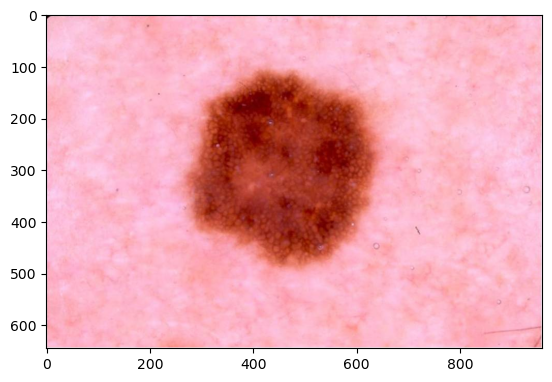

In [4]:
sample = dataset[154]
plt.imshow(sample['image'])

### Segmentation

- DeepCut : NCUT Loss

In [5]:
config = SegmenterConfig(
    segmentation_type="ncut",
    alpha=5.0,
    feature_extractor_config=FeatureExtractionConfig(
        model_name="facebook/dino-vits8",
        device="cuda",
        feature_type="key",
    ),
    activation="silu",
    num_layers=1,
    conv_type="arma",
    hidden_dim=32,
    num_clusters=2,
    device="cuda",
    threshold=0.6
)

In [6]:
segmenter_ncut = Segmenter(config)

Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vits8 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Optimizing:   0%|          | 0/30 [00:00<?, ?it/s]

IoU: 0.962


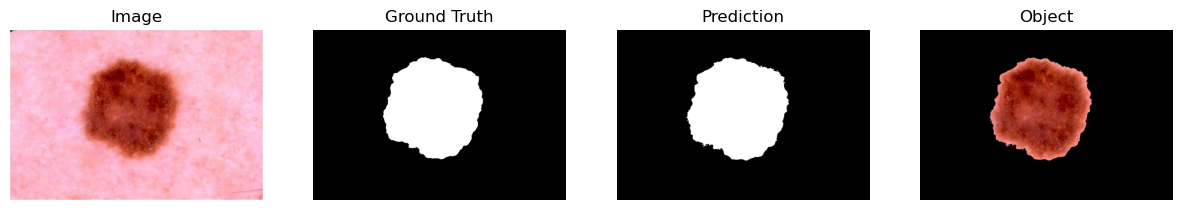

In [7]:
result = segmenter_ncut.segment(sample['image'], lr=0.001, n_iters=30, show_progress=True)
display_segmentation_results(sample, result['mask'].astype(int).astype(bool))

In [8]:
torch.cuda.empty_cache()

- DeepCut : CC Loss

In [9]:
config = SegmenterConfig(
    segmentation_type="cc",
    alpha=4.0,
    feature_extractor_config=FeatureExtractionConfig(
        model_name="facebook/dino-vits8",
        device="cuda",
        feature_type="key",
    ),
    activation="silu",
    num_layers=1,
    conv_type="gcn",
    hidden_dim=32,
    num_clusters=2,
    device="cuda",
    threshold=0.6
)

In [10]:
segmenter_cc = Segmenter(config)

Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vits8 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Optimizing:   0%|          | 0/100 [00:00<?, ?it/s]

IoU: 0.964


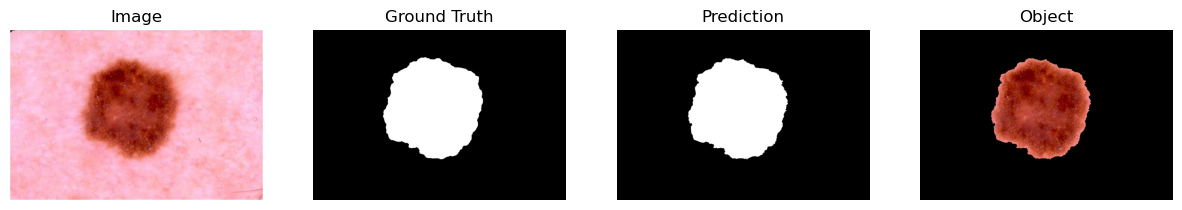

In [11]:
result = segmenter_cc.segment(sample['image'], lr=0.001, n_iters=100, show_progress=True)
display_segmentation_results(sample, result['mask'].astype(bool).astype(int))

In [12]:
torch.cuda.empty_cache()

- UnSegGNet / UnSeGArmaNet

In [13]:
config = SegmenterConfig(
    segmentation_type="dmon",
    alpha=5.0,
    feature_extractor_config=FeatureExtractionConfig(
        model_name="facebook/dino-vits8",
        device="cuda",
        feature_type="key",
    ),
    activation="silu",
    num_layers=1,
    conv_type="arma",
    hidden_dim=32,
    num_clusters=2,
    device="cuda",
    threshold=0.6
)

In [14]:
segmenter_dmon = Segmenter(config)

Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vits8 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Optimizing:   0%|          | 0/70 [00:00<?, ?it/s]

IoU: 0.907


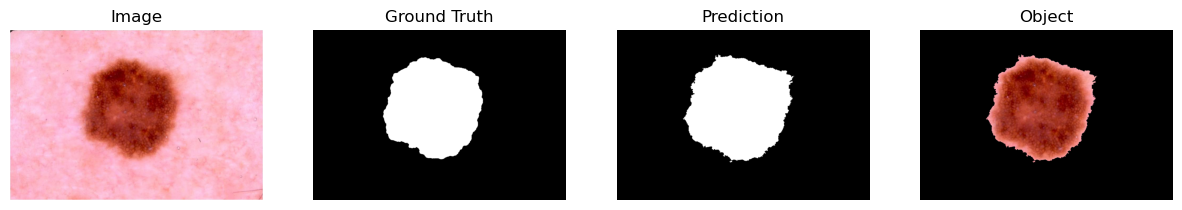

In [15]:
result = segmenter_dmon.segment(sample['image'], lr=0.001, n_iters=70, show_progress=True)
display_segmentation_results(sample, result['mask'].astype(bool).astype(int))

- ISIC

/home/abdelnour/Documents/ESI/5eme_anne/GNN-MiniProject/code/notebooks/../src/segmentation/segmentation.py:275: RuntimeWarning: divide by zero encountered in scalar divide
  r2 = max(a2,b2) / min(a2,b2)
/home/abdelnour/Documents/ESI/5eme_anne/GNN-MiniProject/code/notebooks/../src/segmentation/segmentation.py:271: RuntimeWarning: divide by zero encountered in scalar divide
  r1 = max(a1,b1) / min(a1,b1)


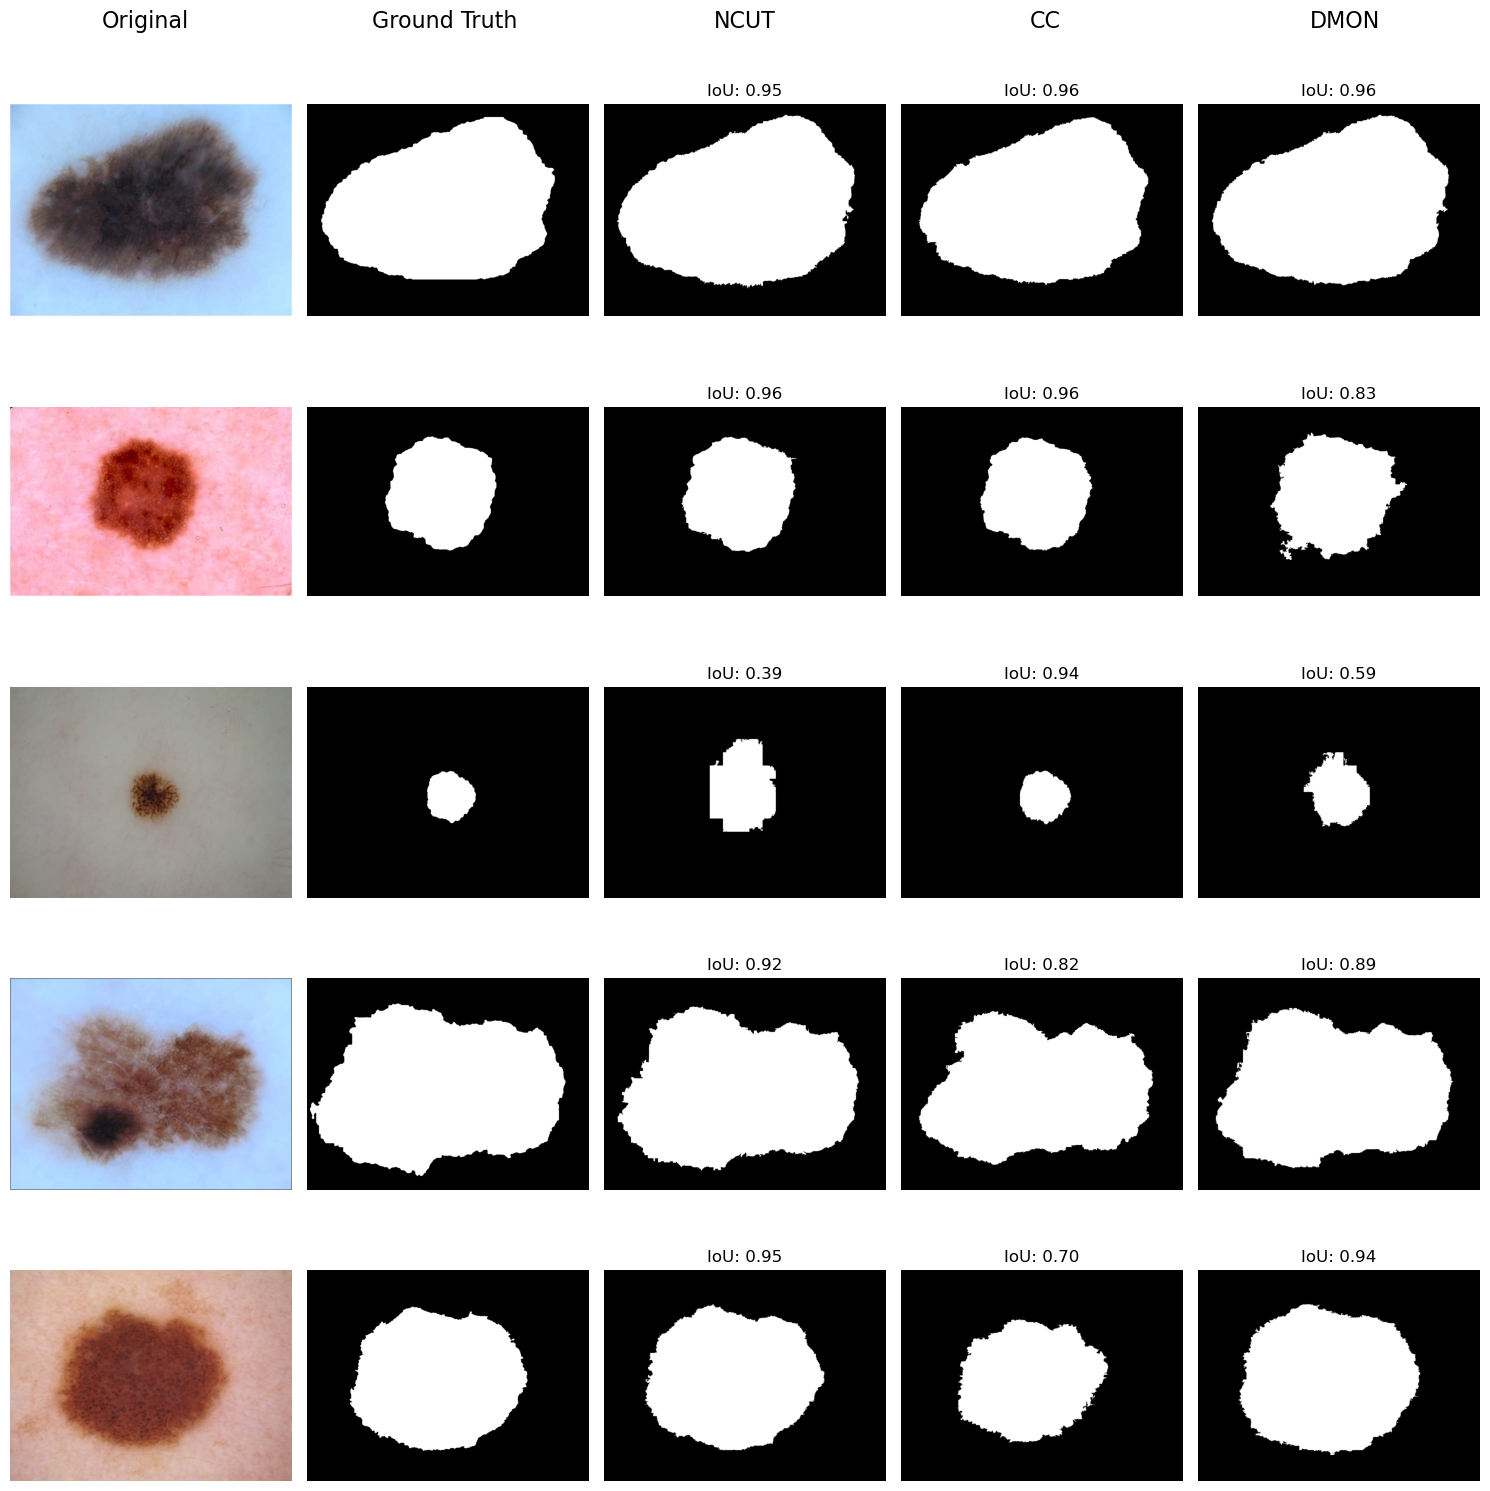

In [69]:
indices = [0,154,655,25,270]
N = len(indices)

fig, axs = plt.subplots(N, 5, figsize=(15, 15))

column_titles = ['Original', 'Ground Truth', 'NCUT', 'CC', 'DMON']

# Add titles to the top row
for col, title in enumerate(column_titles):
    fig.text(0.1 + 0.2 * col, 1.01, title, ha='center', fontsize=16)

for i,j in enumerate(indices):
    
    sample = dataset[j]

    mask_ncut = segmenter_ncut.segment(sample['image'], lr=0.001, n_iters=30, show_progress=False)['mask']
    mask_cc = segmenter_cc.segment(sample['image'], lr=0.001, n_iters=100, show_progress=False)['mask']
    mask_dmon = segmenter_dmon.segment(sample['image'], lr=0.001, n_iters=70, show_progress=False)['mask']

    ncut_iou = iou(sample['mask'], mask_ncut)
    cc_iou = iou(sample['mask'], mask_cc)
    dmon_iou = iou(sample['mask'], mask_dmon)

    ncut_iou_inv = iou(sample['mask'], 255 - mask_ncut)
    cc_iou_inv = iou(sample['mask'], 255 - mask_cc)
    dmon_iou_inv = iou(sample['mask'], 255 - mask_dmon)

    if ncut_iou_inv > ncut_iou:
        mask_ncut = 255 - mask_ncut
        ncut_iou = ncut_iou_inv

    if cc_iou_inv > cc_iou:
        mask_cc = 255 - mask_cc
        cc_iou = cc_iou_inv

    if dmon_iou_inv > dmon_iou:
        mask_dmon = 255 - mask_dmon
        dmon_iou = dmon_iou_inv

    axs[i, 0].imshow(sample['image'])
    axs[i, 0].axis('off')

    axs[i, 1].imshow(sample['mask'], cmap='gray')
    axs[i, 1].axis('off')

    axs[i, 2].imshow(mask_ncut.astype(bool).astype(int), cmap='gray')
    axs[i, 2].set_title(f"IoU: {ncut_iou:.2f}")
    axs[i, 2].axis('off')

    axs[i, 3].imshow(mask_cc.astype(bool).astype(int), cmap='gray')
    axs[i, 3].set_title(f"IoU: {cc_iou:.2f}")
    axs[i, 3].axis('off')

    axs[i, 4].imshow(mask_dmon.astype(bool).astype(int), cmap='gray')
    axs[i, 4].set_title(f"IoU: {dmon_iou:.2f}")
    axs[i, 4].axis('off')

plt.tight_layout()

- EMD

In [71]:
dataset = EMD6Dataset(root=EMDS_6_DIR)

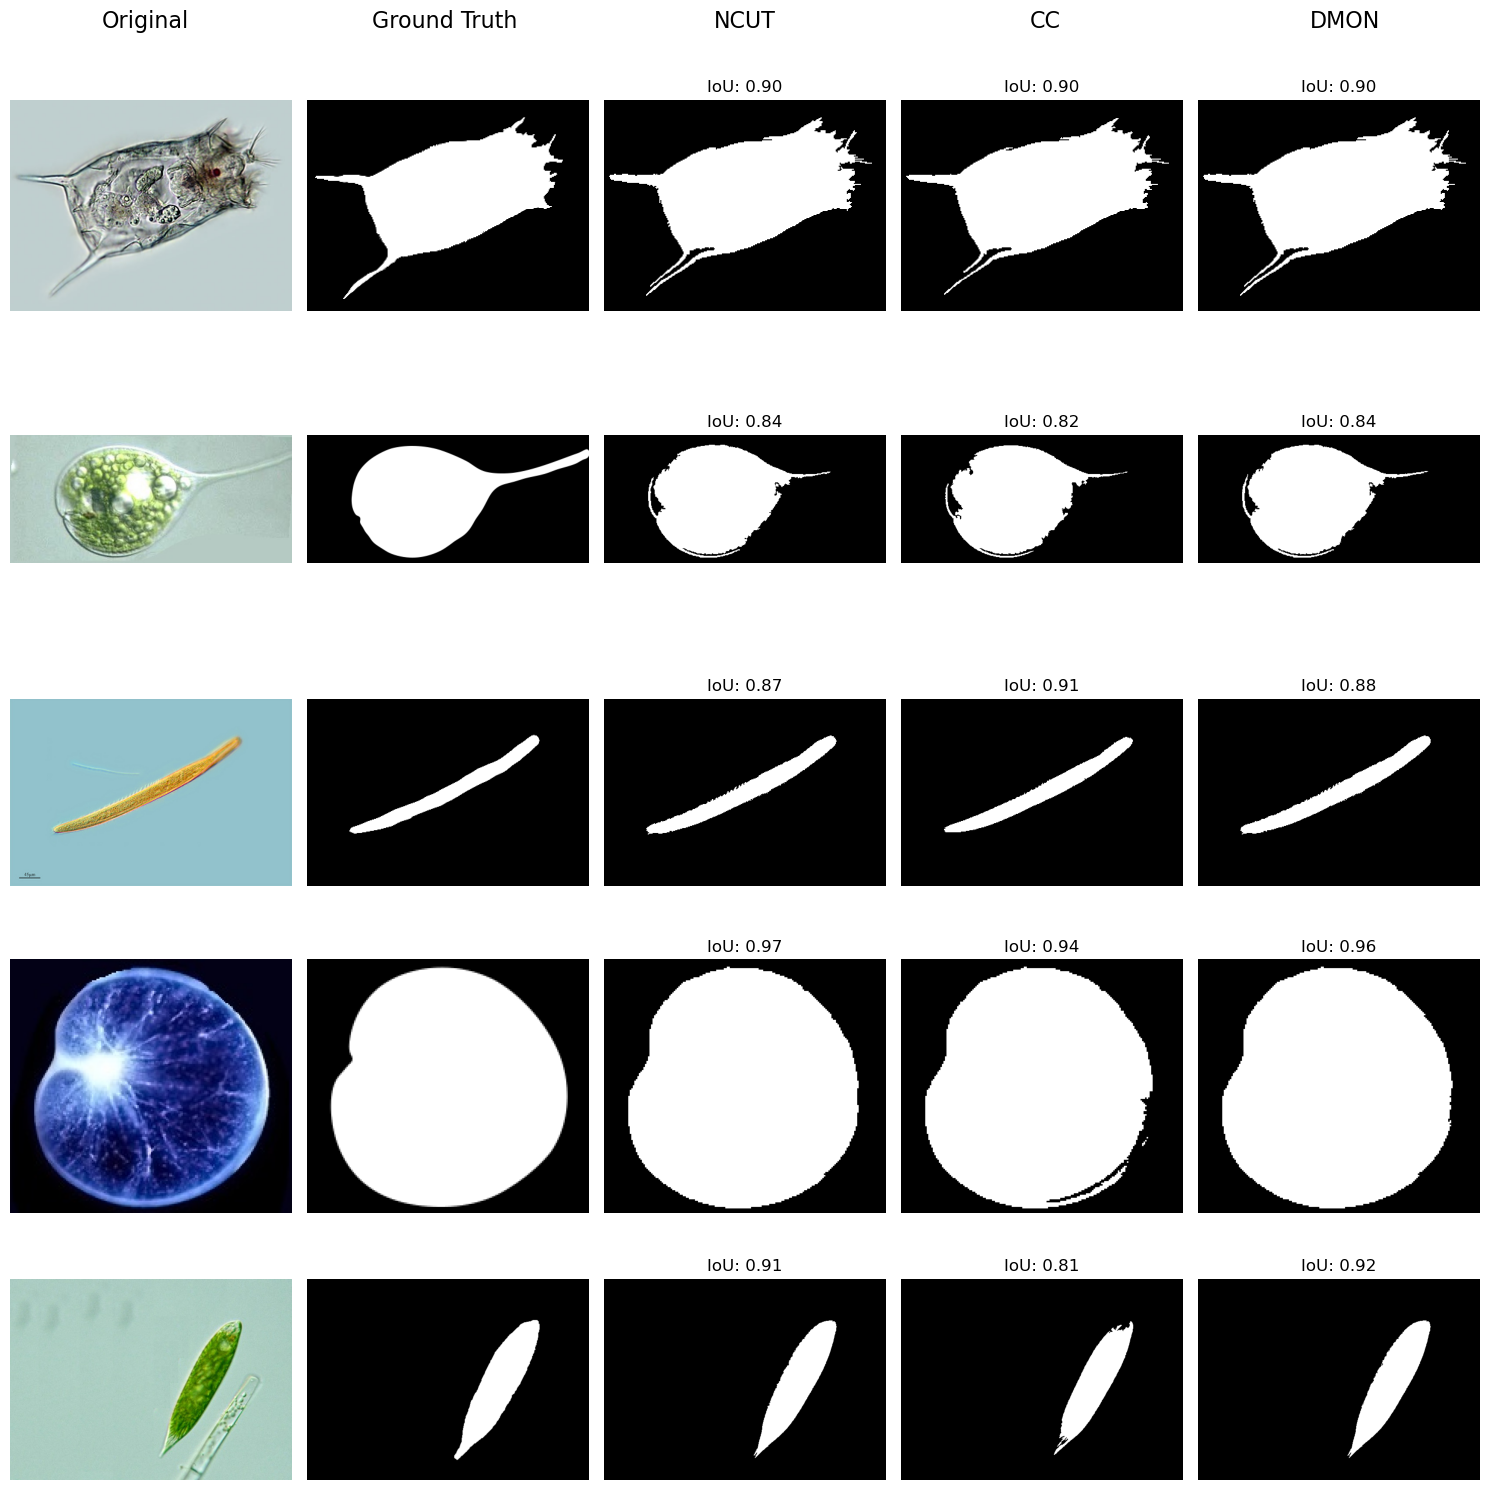

In [141]:
indices = [0,105,205,314,574]
N = len(indices)

fig, axs = plt.subplots(N, 5, figsize=(15, 15))

column_titles = ['Original', 'Ground Truth', 'NCUT', 'CC', 'DMON']

# Add titles to the top row
for col, title in enumerate(column_titles):
    fig.text(0.1 + 0.2 * col, 1.01, title, ha='center', fontsize=16)

for i,j in enumerate(indices):
    
    sample = dataset[j]

    mask_ncut = segmenter_ncut.segment(sample['image'], lr=0.001, n_iters=30, show_progress=False)['mask']
    mask_cc = segmenter_cc.segment(sample['image'], lr=0.001, n_iters=100, show_progress=False)['mask']
    mask_dmon = segmenter_dmon.segment(sample['image'], lr=0.001, n_iters=50, show_progress=False)['mask']

    ncut_iou = iou(sample['mask'], mask_ncut)
    cc_iou = iou(sample['mask'], mask_cc)
    dmon_iou = iou(sample['mask'], mask_dmon)

    ncut_iou_inv = iou(sample['mask'], 255 - mask_ncut)
    cc_iou_inv = iou(sample['mask'], 255 - mask_cc)
    dmon_iou_inv = iou(sample['mask'], 255 - mask_dmon)

    if ncut_iou_inv > ncut_iou:
        mask_ncut = 255 - mask_ncut
        ncut_iou = ncut_iou_inv

    if cc_iou_inv > cc_iou:
        mask_cc = 255 - mask_cc
        cc_iou = cc_iou_inv

    if dmon_iou_inv > dmon_iou:
        mask_dmon = 255 - mask_dmon
        dmon_iou = dmon_iou_inv

    axs[i, 0].imshow(sample['image'])
    axs[i, 0].axis('off')

    axs[i, 1].imshow(sample['mask'], cmap='gray')
    axs[i, 1].axis('off')

    axs[i, 2].imshow(mask_ncut.astype(bool).astype(int), cmap='gray')
    axs[i, 2].set_title(f"IoU: {ncut_iou:.2f}")
    axs[i, 2].axis('off')

    axs[i, 3].imshow(mask_cc.astype(bool).astype(int), cmap='gray')
    axs[i, 3].set_title(f"IoU: {cc_iou:.2f}")
    axs[i, 3].axis('off')

    axs[i, 4].imshow(mask_dmon.astype(bool).astype(int), cmap='gray')
    axs[i, 4].set_title(f"IoU: {dmon_iou:.2f}")
    axs[i, 4].axis('off')

plt.tight_layout()